In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

# 加载保存的模型
loaded_model = joblib.load('lightgbm_model.pkl')

In [14]:
# 读取数据
data_path = r'D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\test (1).csv'
df = pd.read_csv(data_path)

# 去掉相关系数低的列
low_correlation_columns = ['Weather_Relative_Humidity','Wind_Direction','Weather_Daily_Rainfall',]
df.drop(columns=low_correlation_columns, inplace=True)

print(df.head())    # 查看数据内容
# 检测缺失值
missing_values = df.isnull().sum()
print("缺失值检测：")
print(missing_values)

             timestamp  Wind_Speed  Weather_Temperature_Celsius  \
0  2014-12-01 00:00:00    1.543046                    22.941143   
1  2014-12-01 00:05:00    1.698924                    22.919127   
2  2014-12-01 00:10:00    1.214031                    22.967030   
3  2014-12-01 00:15:00    1.269350                    22.899157   
4  2014-12-01 00:20:00    0.613787                    22.553745   

   Global_Horizontal_Radiation  Diffuse_Horizontal_Radiation  \
0                     1.964227                      0.545184   
1                     2.168196                      0.741597   
2                     1.960341                      0.600100   
3                     1.986552                      0.632939   
4                     2.938216                      1.424688   

   Radiation_Global_Tilted  Radiation_Diffuse_Tilted  
0                46.306447                       0.0  
1                46.309034                       0.0  
2                46.311621                     

In [15]:
# 检测并填补异常值（使用平均值和标准差法）
def detect_and_fill_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound))
    df[column].interpolate(method='cubic', inplace=True)

columns_to_check = ['Wind_Speed',
       'Weather_Temperature_Celsius', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted']

print("异常值填补：")
for column in columns_to_check:
    detect_and_fill_outliers(df, column)
    print(f"{column} 异常值已填补")
# 做一下特征工程

# 定义常量
a = -3.23
b = -0.13
E_o = 1000
delta_T = 13
# 计算 T_c
df['T_c'] = (df['Radiation_Global_Tilted'] * np.exp(a + b * df['Wind_Speed'])
                     + df['Weather_Temperature_Celsius']) + (df['Radiation_Global_Tilted'] / E_o) * delta_T

异常值填补：
Wind_Speed 异常值已填补
Weather_Temperature_Celsius 异常值已填补
Global_Horizontal_Radiation 异常值已填补
Diffuse_Horizontal_Radiation 异常值已填补
Radiation_Global_Tilted 异常值已填补
Radiation_Diffuse_Tilted 异常值已填补


In [16]:
X = df.drop(columns=['timestamp'])  # 除了目标列，其他列是特征

# 数据标准化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

scaler_traget = MinMaxScaler(feature_range=(0, 1))
df_step3 = pd.read_csv("D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step3_data.csv")
df_step3.loc[df_step3['Active_Power'] < 0, 'Active_Power'] = 0
scaler_traget.fit_transform(np.array(df_step3['Active_Power']).reshape(-1, 1))


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [17]:
# 预测
y_pred = loaded_model.best_estimator_.predict(X_scaled)
# 反归一化
y_pred_scaled = scaler_traget.inverse_transform(y_pred.reshape(-1, 1)).flatten()

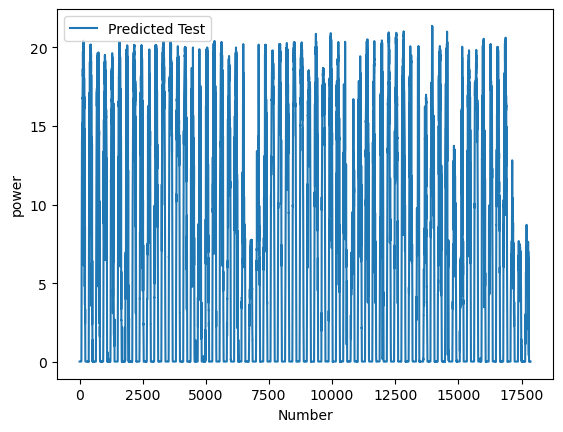

In [18]:
plt.plot(y_pred_scaled, label='Predicted Test')
plt.xlabel('Number')
plt.ylabel('power')
plt.legend()
# plt.savefig(
#     "/Users/Arithmetic/pythonProject/lstm+attention/result_pics/lstm+attention_nasdaq_epoch{0}.png".format(EPOCHS))
plt.show()

In [19]:
np.save('D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\lightgbm_data', y_pred_scaled)